In [1]:
!pip install keras-tuner
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
cudf 23.4.0 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.19.6 which is incompatible.
beatrix-ju

In [2]:
#ignore warnings
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

import tensorflow as tf
# data generator 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# wandb
import wandb
from wandb.keras import WandbCallback

DATA_PATH = '/kaggle/input/fashion-product-images-dataset/'

%matplotlib inline

# Exploratory and Visualizations

## Images Dataframe

In [3]:
images_df = pd.read_csv(
    os.path.join(DATA_PATH, 'fashion-dataset', 'images.csv')
)

In [4]:
images_df.head(2)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


## Product Meta Data Dataframe

In [5]:
styles_df = pd.read_csv(
    os.path.join(DATA_PATH, 'fashion-dataset', 'styles.csv'),
    on_bad_lines='skip'
)

In [6]:
styles_df.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans


## Create Unique ID in both Dataframes

In [7]:
images_df.head(2)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [8]:
# tạo id để merge với metadata df
images_df['id'] = images_df['filename']\
.apply(lambda filename: filename\
       .replace('.jpg', '')).astype(int)

In [9]:
images_df.head(2)

,filename,link,id
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386


## Merging the two dataframes

In [10]:
data = styles_df.merge(images_df, on='id', how='left')
data.head(2)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [11]:
# chuyển filename thành filepath
data['filename'] = data['filename']\
.apply(lambda filename: os.path.join(DATA_PATH, 'fashion-dataset', 'images', filename))
data.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...


## Removing Products for which images are not present

In [12]:
# lấy danh sách ảnh trong dataset
image_files = os.listdir(
    os.path.join(DATA_PATH, 'fashion-dataset', 'images')
)
print(len(image_files))

44441


In [13]:
# các file có trong dataset
data['file_found'] = data['id'].apply(lambda idx: '{}.jpg'.format(idx)  in image_files)

In [14]:
data['file_found'].value_counts()

True     44419
False        5
Name: file_found, dtype: int64

In [15]:
# xóa bỏ file không có ảnh trong dataset
data = data[data['file_found']].reset_index(drop=True)
print(data.shape)
data.head(2)

(44419, 13)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True


## Checking for Missing data

In [16]:
data.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
file_found              0
dtype: int64

## Visualizations

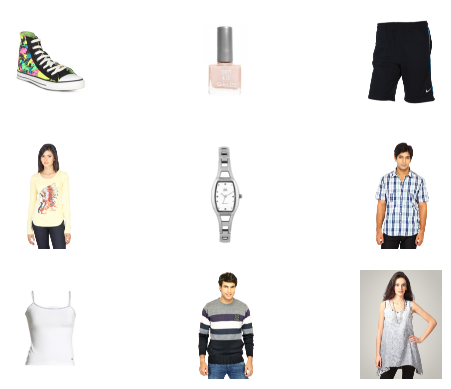

In [17]:
# trực quan một số hình ảnh trong datasets
def dislay_image(image_files):
    random.shuffle(image_files)
    for idx, image_file in enumerate(image_files[0:9]):
        plt.subplot(3, 3, idx+1)
        image_path = os.path.join(DATA_PATH, 'fashion-dataset', 'images', image_file)
        image_arr = cv2.imread(image_path)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image_arr)
        plt.axis("off")

dislay_image(image_files) 

In [18]:
# masterCategory count 
gr_data_masterCate = data.groupby('masterCategory').size()
gr_data_masterCate_sorted= gr_data_masterCate.sort_values()
gr_data_masterCate_sorted

masterCategory
Home                  1
Sporting Goods       25
Free Items          105
Personal Care      2403
Footwear           9219
Accessories       11274
Apparel           21392
dtype: int64

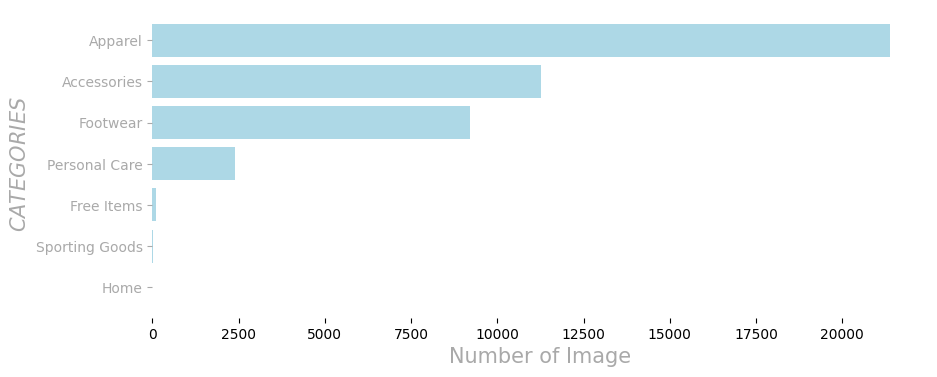

In [19]:
plt.figure(figsize = (10, 4))
with plt.rc_context({"ytick.color":"darkgrey"}):
    plt.barh(gr_data_masterCate_sorted.index, gr_data_masterCate_sorted.values, color='lightblue')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylabel("$CATEGORIES$", size=15, color="darkgrey")
plt.xlabel("Number of Image", size=15, color="darkgrey")
plt.show()

In [20]:
# subCategory count 
gr_data_subCate = data.groupby('subCategory').size()
gr_data_subCate_sorted= gr_data_subCate.sort_values()

In [21]:
len(gr_data_subCate_sorted)

45

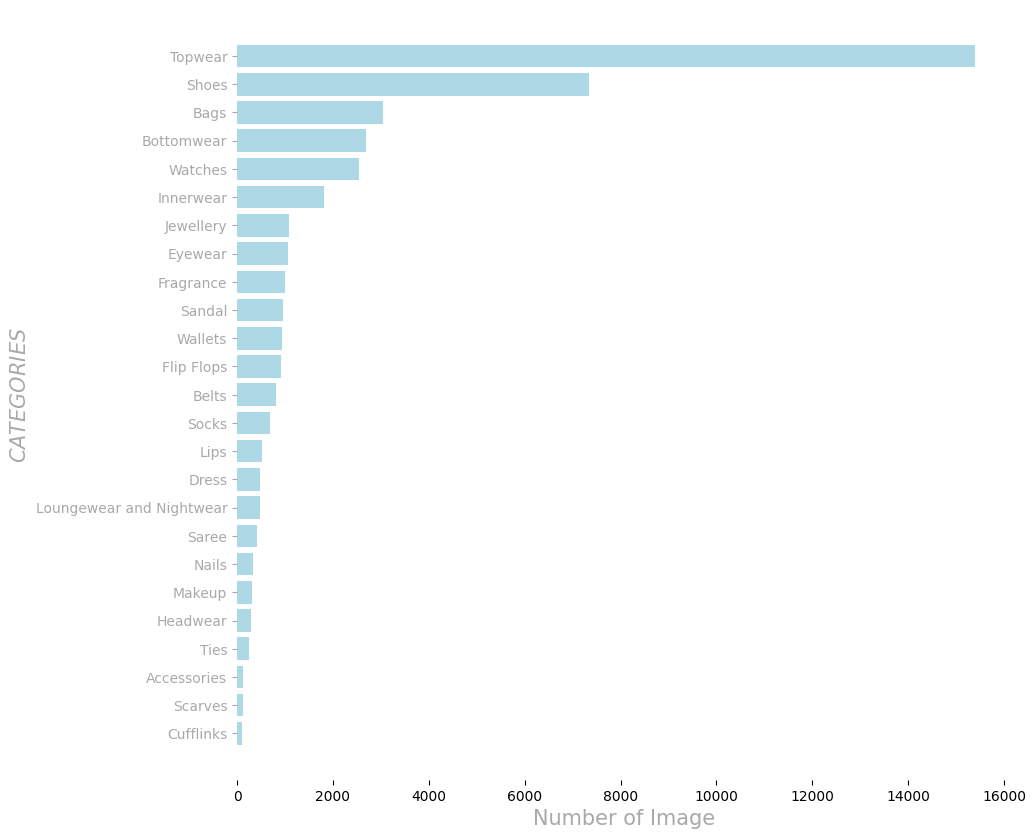

In [22]:
plt.figure(figsize = (10, 10))
with plt.rc_context({"ytick.color":"darkgrey"}):
    plt.barh(gr_data_subCate_sorted[-25:].index, gr_data_subCate_sorted[-25:].values, color='lightblue')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylabel("$CATEGORIES$", size=15, color="darkgrey")
plt.xlabel("Number of Image", size=15, color="darkgrey")
plt.show()

In [23]:
# articleType count 
gr_data_articleType = data.groupby('articleType').size()
gr_data_articleType_sorted = gr_data_articleType.sort_values()

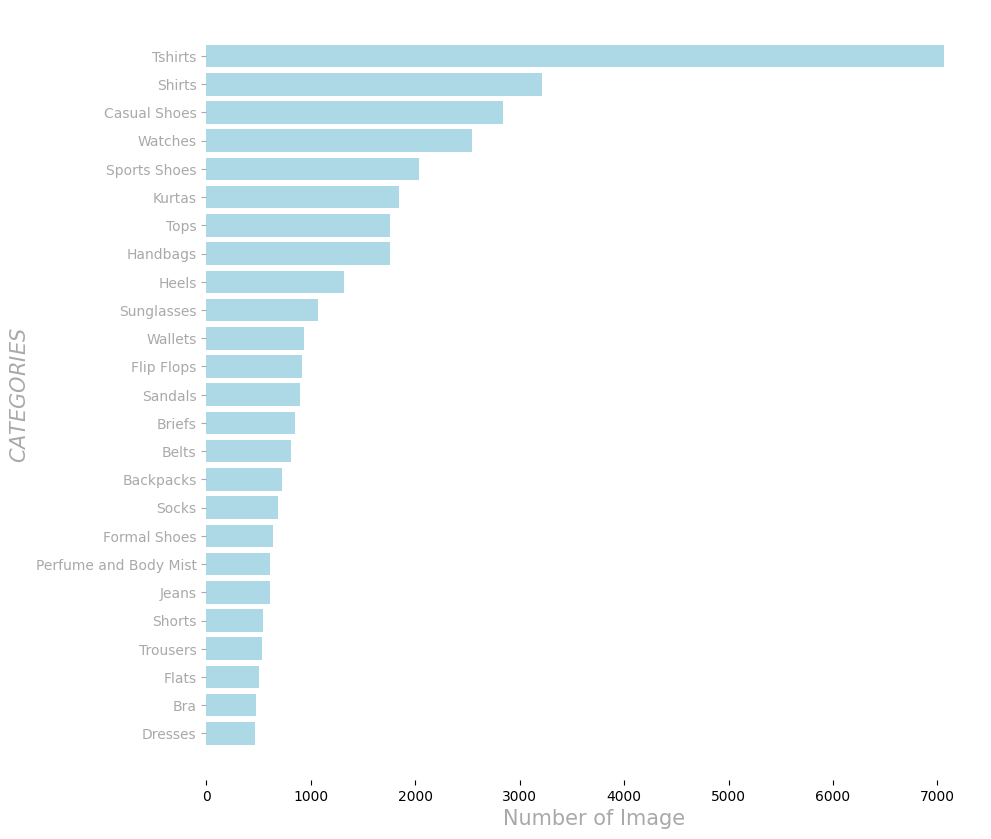

In [24]:
plt.figure(figsize = (10, 10))
with plt.rc_context({"ytick.color":"darkgrey"}):
    plt.barh(gr_data_articleType_sorted[-25:].index, gr_data_articleType_sorted[-25:].values, color='lightblue')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylabel("$CATEGORIES$", size=15, color="darkgrey")
plt.xlabel("Number of Image", size=15, color="darkgrey")
plt.show()

## final data

In [25]:
# lấy 20 danh mục 

In [26]:
categoricals = sorted(list(gr_data_subCate_sorted.index[-20:]))

In [27]:
data_20 = data[data['subCategory'].isin(categoricals)]

In [28]:
data_20 = data_20[['subCategory', 'filename']]

In [29]:
data_20

,subCategory,filename
0,Topwear,/kaggle/input/fashion-product-images-dataset/f...
1,Bottomwear,/kaggle/input/fashion-product-images-dataset/f...
2,Watches,/kaggle/input/fashion-product-images-dataset/f...
3,Bottomwear,/kaggle/input/fashion-product-images-dataset/f...
4,Topwear,/kaggle/input/fashion-product-images-dataset/f...
...,...,...
44414,Shoes,/kaggle/input/fashion-product-images-dataset/f...
44415,Flip Flops,/kaggle/input/fashion-product-images-dataset/f...
44416,Topwear,/kaggle/input/fashion-product-images-dataset/f...
44417,Fragrance,/kaggle/input/fashion-product-images-dataset/f...


In [30]:
data_20.groupby('subCategory').size().sort_values(ascending=False)

subCategory
Topwear                     15398
Shoes                        7343
Bags                         3055
Bottomwear                   2693
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
dtype: int64

In [31]:
# mỗi danh mục lấy tối đa 600 ảnh


In [32]:
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split

In [33]:
n_samples = 600
lst_df = []
for categorical in categoricals:
    df_class_tmp = data_20.loc[data_20['subCategory'] == categorical]
    if df_class_tmp.shape[0] < n_samples:
        df_resample_tmp = df_class_tmp
    else:
        df_resample_tmp = resample(df_class_tmp, n_samples=n_samples, random_state=42)
    lst_df.append(df_resample_tmp)
df = pd.concat(lst_df)

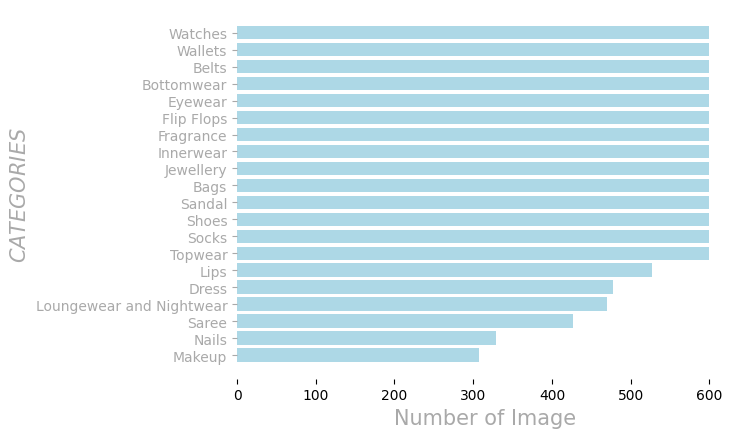

In [34]:
cate = df.groupby('subCategory').size().sort_values()

# plt.figure(figsize = (10, 10))
with plt.rc_context({"ytick.color":"darkgrey"}):
    plt.barh(cate[-25:].index, cate[-25:].values, color='lightblue')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylabel("$CATEGORIES$", size=15, color="darkgrey")
plt.xlabel("Number of Image", size=15, color="darkgrey")
plt.show()

In [35]:
df.shape

(10938, 2)

In [36]:
df = shuffle(df, random_state=42)
df = df.reset_index(drop=True)

In [37]:
df.rename({'subCategory':'categorical'}, axis=1, inplace=True)

In [38]:
# final data
data = df
data

,categorical,filename
0,Bags,/kaggle/input/fashion-product-images-dataset/f...
1,Makeup,/kaggle/input/fashion-product-images-dataset/f...
2,Lips,/kaggle/input/fashion-product-images-dataset/f...
3,Fragrance,/kaggle/input/fashion-product-images-dataset/f...
4,Dress,/kaggle/input/fashion-product-images-dataset/f...
...,...,...
10933,Lips,/kaggle/input/fashion-product-images-dataset/f...
10934,Jewellery,/kaggle/input/fashion-product-images-dataset/f...
10935,Lips,/kaggle/input/fashion-product-images-dataset/f...
10936,Belts,/kaggle/input/fashion-product-images-dataset/f...


# Train-val-test Split

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
train_df, test_df = train_test_split(data,\
                                     test_size=0.2,\
                                     random_state=42,\
                                     stratify=data['categorical'])
valid_df, test_df = train_test_split(test_df,\
                                      test_size=0.5,\
                                      random_state=42,\
                                      stratify=test_df['categorical'])

In [41]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [42]:
train_df

,categorical,filename
0,Fragrance,/kaggle/input/fashion-product-images-dataset/f...
1,Belts,/kaggle/input/fashion-product-images-dataset/f...
2,Sandal,/kaggle/input/fashion-product-images-dataset/f...
3,Bags,/kaggle/input/fashion-product-images-dataset/f...
4,Shoes,/kaggle/input/fashion-product-images-dataset/f...
...,...,...
8745,Innerwear,/kaggle/input/fashion-product-images-dataset/f...
8746,Dress,/kaggle/input/fashion-product-images-dataset/f...
8747,Nails,/kaggle/input/fashion-product-images-dataset/f...
8748,Fragrance,/kaggle/input/fashion-product-images-dataset/f...


## Data Augmentation

In [43]:
datagen = ImageDataGenerator(rescale=1/255.,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

train_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                             target_size=(224,224),
                                             x_col='filename',
                                            y_col='categorical',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                              seed=42)


test_datagen = ImageDataGenerator(rescale=1/255.)
valid_generator = test_datagen.flow_from_dataframe(dataframe=valid_df,
                                             target_size=(224,224),
                                             x_col='filename',
                                            y_col='categorical',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                              seed=42)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='categorical',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 8750 validated image filenames belonging to 20 classes.
Found 1094 validated image filenames belonging to 20 classes.
Found 1094 validated image filenames belonging to 20 classes.


In [44]:
# tmp

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [46]:
def build_model(name, weights_path=None):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='leaky_relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(20, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)
    if weights_path:
        model.load_weights(weights_path)
    return model

In [47]:
import time

In [48]:
NAME = "vgg19-{}".format(int(time.time()))
model = build_model(NAME)
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19-1683902131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                   

In [49]:
lr = 0.01
epochs = 10
## Initlisazie wandb project
wandb.init(project='CBIR-fashion product dataset',
           name= NAME,
          config={
              "learning_rate": lr,
              "Batch_normalization": True,
              "Batch_size" : 64,
              "Dropout" : "0.4",
              "architecture": "VGG19",
              "dataset": "fashion-product-images-dataset",
              "epochs": epochs,
              "data generator" : True
          }
          )

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [50]:
wandb_callback = WandbCallback()

filepath = "{}_loss_opti.hdf5".format(NAME)

checkpoint1 = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [51]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [52]:
history = model.fit_generator(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    callbacks=[checkpoint1, wandb_callback])

Epoch 1/10
273/273 [==============================] - ETA: 0s - loss: 1.7569 - accuracy: 0.6379
Epoch 1: val_loss improved from inf to 0.88509, saving model to vgg19-1683902131_loss_opti.hdf5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230512_143602-w3xxqffv/files/model-best)... Done. 11.4s


273/273 [==============================] - 406s 1s/step - loss: 1.7569 - accuracy: 0.6379 - val_loss: 0.8851 - val_accuracy: 0.7803
Epoch 2/10
273/273 [==============================] - ETA: 0s - loss: 1.0366 - accuracy: 0.7550
Epoch 2: val_loss improved from 0.88509 to 0.67693, saving model to vgg19-1683902131_loss_opti.hdf5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230512_143602-w3xxqffv/files/model-best)... Done. 9.3s


273/273 [==============================] - 343s 1s/step - loss: 1.0366 - accuracy: 0.7550 - val_loss: 0.6769 - val_accuracy: 0.7858
Epoch 3/10
273/273 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7971
Epoch 3: val_loss improved from 0.67693 to 0.40303, saving model to vgg19-1683902131_loss_opti.hdf5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230512_143602-w3xxqffv/files/model-best)... Done. 12.9s


273/273 [==============================] - 335s 1s/step - loss: 0.7225 - accuracy: 0.7971 - val_loss: 0.4030 - val_accuracy: 0.8603
Epoch 4/10
273/273 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.8238
Epoch 4: val_loss did not improve from 0.40303
273/273 [==============================] - 307s 1s/step - loss: 0.5521 - accuracy: 0.8238 - val_loss: 0.4131 - val_accuracy: 0.8640
Epoch 5/10
273/273 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.8490
Epoch 5: val_loss improved from 0.40303 to 0.33640, saving model to vgg19-1683902131_loss_opti.hdf5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230512_143602-w3xxqffv/files/model-best)... Done. 9.9s


273/273 [==============================] - 301s 1s/step - loss: 0.4712 - accuracy: 0.8490 - val_loss: 0.3364 - val_accuracy: 0.8869
Epoch 6/10
273/273 [==============================] - ETA: 0s - loss: 0.4265 - accuracy: 0.8581
Epoch 6: val_loss improved from 0.33640 to 0.27716, saving model to vgg19-1683902131_loss_opti.hdf5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230512_143602-w3xxqffv/files/model-best)... Done. 12.5s


273/273 [==============================] - 327s 1s/step - loss: 0.4265 - accuracy: 0.8581 - val_loss: 0.2772 - val_accuracy: 0.9108
Epoch 7/10
273/273 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.8663
Epoch 7: val_loss improved from 0.27716 to 0.21779, saving model to vgg19-1683902131_loss_opti.hdf5


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230512_143602-w3xxqffv/files/model-best)... Done. 10.8s


273/273 [==============================] - 320s 1s/step - loss: 0.4164 - accuracy: 0.8663 - val_loss: 0.2178 - val_accuracy: 0.9210
Epoch 8/10
273/273 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8704
Epoch 8: val_loss did not improve from 0.21779
273/273 [==============================] - 301s 1s/step - loss: 0.3917 - accuracy: 0.8704 - val_loss: 0.2518 - val_accuracy: 0.9173
Epoch 9/10
273/273 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8690
Epoch 9: val_loss did not improve from 0.21779
273/273 [==============================] - 266s 976ms/step - loss: 0.4028 - accuracy: 0.8690 - val_loss: 0.2289 - val_accuracy: 0.9200
Epoch 10/10
273/273 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8652
Epoch 10: val_loss did not improve from 0.21779
273/273 [==============================] - 272s 997ms/step - loss: 0.4149 - accuracy: 0.8652 - val_loss: 0.3129 - val_accuracy: 0.9044


In [ ]:
# model.save(filepath)

In [53]:
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.387500524520874
Test accuracy: 0.8839122653007507


In [55]:
from tensorflow.keras.models import load_model
best_model = load_model(filepath)

In [56]:
score = best_model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.30928775668144226
Test accuracy: 0.8921389579772949


In [57]:
IMAGESIZE = 224
CHANNELS = 3
def image_preprocess(image_path):
    image_orig = cv2.imread(image_path)
    image_arr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
    image_arr = cv2.resize(image_arr, (IMAGESIZE, IMAGESIZE))
    image_arr = image_arr/255.
    image_arr = image_arr.reshape(-1, IMAGESIZE, IMAGESIZE, CHANNELS)
    return image_arr

In [59]:
test_df.filename[1]

'/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/50892.jpg'

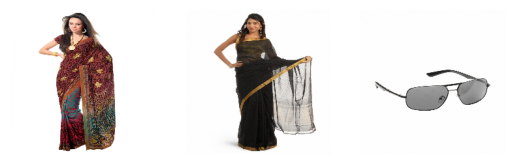

In [106]:
anchor_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/50892.jpg'
pos_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/45986.jpg'
neg_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/29863.jpg'
image_arr1 = image_preprocess(anchor_path)
image_arr2 = image_preprocess(pos_path)
image_arr3 = image_preprocess(neg_path)
image_lst = [image_arr1, image_arr2, image_arr3]
for i, image_arr in enumerate(image_lst):
    plt.subplot(1, 3, i+1)
    plt.imshow(image_arr[0])
    plt.axis(False)
plt.show()

In [61]:
y_hat = model.predict(image_arr)

1/1 [==============================] - 1s 1s/step


In [62]:
y_hat.argmax()

14

In [63]:
categoricals[14]

'Saree'

In [65]:
best_model.layers

In [71]:
CBIR_model = Model(inputs=best_model.input, outputs=best_model.layers[-4].output)

In [107]:
prehashcode1 = CBIR_model.predict(image_arr1)
prehashcode2 = CBIR_model.predict(image_arr2)
prehashcode3 = CBIR_model.predict(image_arr3)

1/1 [==============================] - 0s 22ms/step


In [74]:
prehashcode.shape

(1, 1024)

In [108]:
hashcode1 = np.where(prehashcode1<0.5, 0, 1)
hashcode2 = np.where(prehashcode2<0.5, 0, 1)
hashcode3 = np.where(prehashcode3<0.5, 0, 1)

In [120]:
hashcode1 = hashcode1.astype('bool')
hashcode2 = hashcode2.astype('bool')
hashcode3 = hashcode3.astype('bool')

In [118]:
hamming_distance = np.hamming(hashcode1.shape[0]) * np.abs(hashcode1 - hashcode2)

In [122]:
hamming_dist = np.count_nonzero(hashcode1 != hashcode2)

In [123]:
hamming_dist

144

In [124]:
hamming_dist = np.count_nonzero(hashcode1 != hashcode3)
hamming_dist

699

In [125]:
hamming_dist = np.count_nonzero(hashcode2 != hashcode3)
hamming_dist

673